In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from IPython import display
import time
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
env = gym.make('LunarLander-v2', render_mode="rgb_array")

In [2]:
class Actor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(8, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 4)
        )
    
    def forward(self, obs):
        obs = torch.tensor(obs).to(device)
        return self.main(obs)

In [3]:
actor = Actor().to(device)
optimizer = torch.optim.SGD(actor.parameters(), lr=1e-3)
cross_entropy = nn.CrossEntropyLoss()
N_EPISODES = 5
EPOCHS = 500
DISCOUNT_FACTOR = 0.9

In [4]:
def collect_training_data():
    all_es = []
    all_As = []
    total_reward = 0
    final_reward = 0
    loss = 0
    for _ in range(N_EPISODES):
        As = []
        observation, info = env.reset()
        #img = plt.imshow(env.render())
        terminated = truncated = False
        while not (terminated or truncated):
            action_prob = actor(observation)
            action = torch.multinomial(F.softmax(action_prob, dim=-1), num_samples=1).squeeze()
            e = cross_entropy(action_prob, action)
            observation, reward, terminated, truncated, info = env.step(action.item())
            all_es.append(e)
            As.append(reward)
            #img.set_data(env.render())
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
            total_reward += reward
        final_reward += reward
        env.close()
        
        for i in range(len(As)):
            A = 0
            for j in range(i, len(As)):
                A += As[j]*(DISCOUNT_FACTOR**(j-i))
            As[i] = A

        all_As.extend(As)
    
    all_As = torch.tensor(all_As).to(device)
    all_As = (all_As - torch.mean(all_As))/(torch.std(all_As) + 1e-9)
    for i in range(len(all_es)):
        loss += all_es[i] * all_As[i]
    return loss, total_reward/N_EPISODES, final_reward/N_EPISODES

In [5]:
def training_loop():
    actor.train()
    optimizer.zero_grad()
    loss, total_reward, final_reward = collect_training_data()
    loss.backward()
    optimizer.step()
    return total_reward, final_reward

In [6]:
total_rewards, final_rewards = [], []
for i in range(EPOCHS):
   time1 = time.time()
   total_reward, final_reward = training_loop()
   total_rewards.append(total_reward)
   final_rewards.append(final_reward)
   time2 = time.time()
   print(f'Epoch{i+1}, total reward:{total_reward}, final reward:{final_reward}, time:{round(time2-time1, 2)}')

Epoch1, total reward:-269.07697357368727, final reward:-100.0, time:0.37
Epoch2, total reward:-208.1160661682667, final reward:-100.0, time:0.27
Epoch3, total reward:-123.12858350667022, final reward:-100.0, time:0.2
Epoch4, total reward:-218.54256131370613, final reward:-100.0, time:0.23
Epoch5, total reward:-131.32929067384288, final reward:-100.0, time:0.17
Epoch6, total reward:-215.30672841785616, final reward:-100.0, time:0.18
Epoch7, total reward:-133.67290986277362, final reward:-100.0, time:0.24
Epoch8, total reward:-214.87541109853592, final reward:-100.0, time:0.23
Epoch9, total reward:-285.2628069184895, final reward:-100.0, time:0.21
Epoch10, total reward:-153.74170052315685, final reward:-100.0, time:0.25
Epoch11, total reward:-293.16413518575115, final reward:-100.0, time:0.24
Epoch12, total reward:-296.48818259695594, final reward:-100.0, time:0.26
Epoch13, total reward:-277.9823819555168, final reward:-100.0, time:0.31
Epoch14, total reward:-226.18048140709644, final re

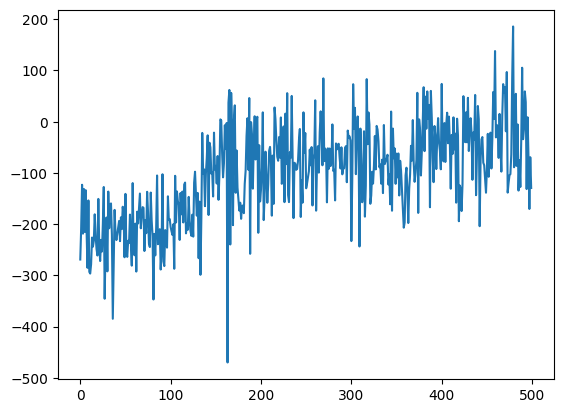

In [7]:
plt.plot(total_rewards)

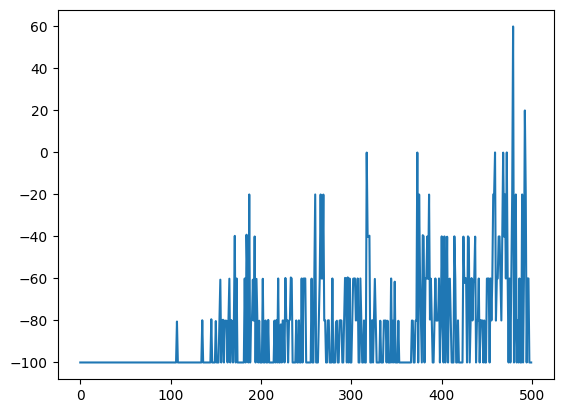

In [8]:
plt.plot(final_rewards)

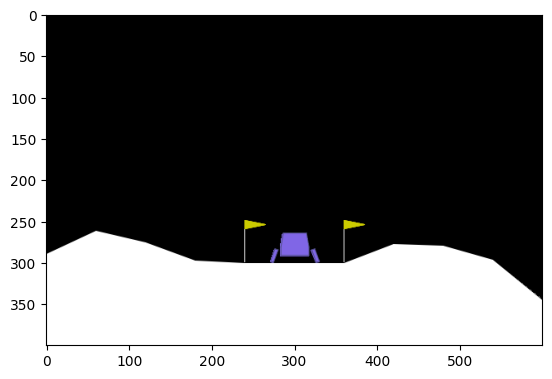

In [16]:
actor.eval()
observation, info = env.reset()
img = plt.imshow(env.render())
terminated = truncated = False
total_reward = 0
while not (terminated or truncated):
    action_prob = actor(observation)
    action = torch.multinomial(F.softmax(action_prob, dim=-1), num_samples=1)
    observation, reward, terminated, truncated, info = env.step(action.item())
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    total_reward += reward
final_reward = reward
env.close()

In [17]:
print(total_reward, final_reward)

233.32606187634238 100
